In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import geopandas
from sklearn import preprocessing
import math

In [2]:
data = pd.read_csv('2020-XTern-DS.csv')
data['Cuisines'].astype('str')
data.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30 minutes
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30 minutes
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65 minutes
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30 minutes
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65 minutes


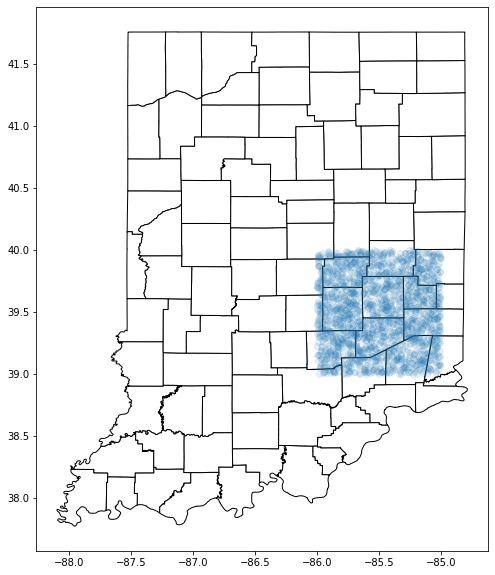

In [3]:
indi = geopandas.read_file('tl_2019_us_county/tl_2019_us_county.shp')
indi = indi[indi['STATEFP']== '18']

map_data = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data.Longitude, data.Latitude))

fig, ax = plt.subplots(figsize=(10,10))
indi.plot(ax=ax, color = 'white', edgecolor='black')
map_data.plot(ax=ax, alpha = 0.1)

In [4]:
# all_cuisine = data['Cuisines'].str.split(pat = ', ', expand = True)
data['Cuisines']= data['Cuisines'].str.split(pat = ', ')
data['Cook_Time'] = data["Cook_Time"].str.replace(" minutes","")
data['Average_Cost'] = data["Average_Cost"].str.replace("$","")
data['Average_Cost'] = data["Average_Cost"].str.replace(",",".")
data['Minimum_Order'] = data["Minimum_Order"].str.replace("$","")
data['Rating'].astype('str')
data = data[data['Rating'] != '-']
data = data[data['Rating'] != 'NEW']
data = data[data['Rating'] != 'Opening Soon']
data = data[data['Votes'] != '-']
data = data[data['Reviews'] != '-']

In [5]:
data['Rating'] = data['Rating'].astype('float')
data['Votes'] = data['Votes'].astype('float')
data['Reviews'] = data['Reviews'].astype('float')
data['Minimum_Order'] = data['Minimum_Order'].astype('float')
data['Average_Cost'] = data['Average_Cost'].astype('float')
data['Trending Rate'] = data['Rating']*data['Rating']*data['Rating'] + (data['Votes']) + (data['Reviews'])

scaler = preprocessing.MinMaxScaler()
data['Trending Rate'] = scaler.fit_transform(data[['Trending Rate']])
data.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,geometry,Trending Rate
0,ID_6321,39.262605,-85.837372,"[Fast Food, Rolls, Burger, Salad, Wraps]",20.0,50.0,3.5,12.0,4.0,30,POINT (-85.83737 39.26261),0.001995
1,ID_2882,39.775933,-85.740581,"[Ice Cream, Desserts]",10.0,50.0,3.5,11.0,4.0,30,POINT (-85.74058 39.77593),0.001931
2,ID_1595,39.253436,-85.123779,"[Italian, Street Food, Fast Food]",15.0,50.0,3.6,99.0,30.0,65,POINT (-85.12378 39.25344),0.009465
3,ID_5929,39.029841,-85.332050,"[Mughlai, North Indian, Chinese]",25.0,99.0,3.7,176.0,95.0,30,POINT (-85.33205 39.02984),0.018803
4,ID_6123,39.882284,-85.517407,"[Cafe, Beverages]",20.0,99.0,3.2,521.0,235.0,65,POINT (-85.51741 39.88228),0.048681


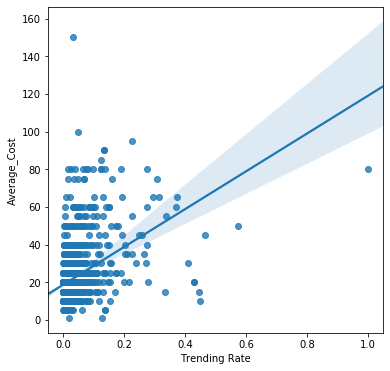

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=data, x = data['Trending Rate'], y = data['Average_Cost'], ax=ax)

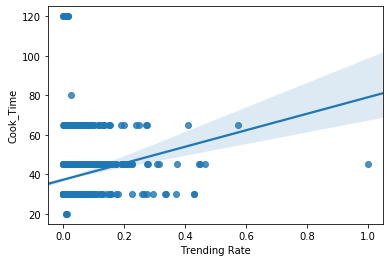

In [7]:
data['Cook_Time'] = data['Cook_Time'].astype('int')
sns.regplot(data=data, y = data['Cook_Time'], x = data['Trending Rate'])

In [8]:
def create_df(data):
    all_cuisine={}
    for i in data.index:
        for j in data['Cuisines'][i]:
            if j in all_cuisine:
                all_cuisine[j]= (all_cuisine[j][0] + 1, all_cuisine[j][1] + data['Rating'][i])
#                 all_cuisine[j][1] = all_cuisine[j][1] + data['Rating'][i]
            else:
                all_cuisine[j] = (1,data['Rating'][i])
    details = []
    types_of_cuisine = []
    for key in all_cuisine:
        details.append([key, all_cuisine[key][0], all_cuisine[key][1]/all_cuisine[key][0]])
        types_of_cuisine.append(key)
    final_df = pd.DataFrame(data=details, columns=['Cuisine','Frequency','Average Rating'])
    final_df = final_df[final_df['Frequency']>50]
    return final_df, types_of_cuisine
new, types_of_cuisine = create_df(data)
new.sort_values(by = ['Average Rating'], ascending = False, inplace= True)
new.head()

,Cuisine,Frequency,Average Rating
30,Continental,83,3.973494
7,Italian,109,3.938532
12,Cafe,79,3.905063
6,Desserts,168,3.761905
27,Pizza,72,3.713889


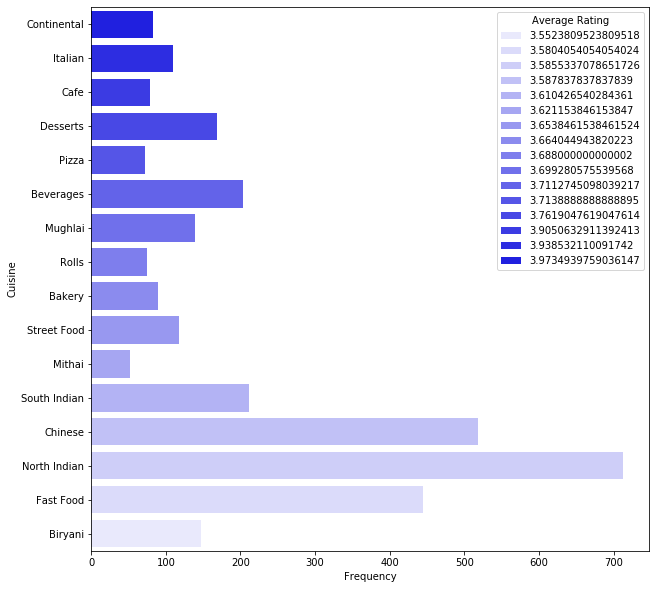

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data = new, y = 'Cuisine',x = 'Frequency', color = 'blue', hue='Average Rating', dodge=False)

In [10]:
tmp = pd.DataFrame(columns= types_of_cuisine)
final = pd.concat([data,tmp], ignore_index=True, sort=False)
# final = final.fillna(0)
final.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,...,Modern Indian,Kashmiri,French,Portuguese,Charcoal Chicken,Awadhi,Frozen Yogurt,Bangladeshi,Coffee,Bihari
0,ID_6321,39.262605,-85.837372,"[Fast Food, Rolls, Burger, Salad, Wraps]",20.0,50.0,3.5,12.0,4.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_2882,39.775933,-85.740581,"[Ice Cream, Desserts]",10.0,50.0,3.5,11.0,4.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_1595,39.253436,-85.123779,"[Italian, Street Food, Fast Food]",15.0,50.0,3.6,99.0,30.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_5929,39.029841,-85.332050,"[Mughlai, North Indian, Chinese]",25.0,99.0,3.7,176.0,95.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_6123,39.882284,-85.517407,"[Cafe, Beverages]",20.0,99.0,3.2,521.0,235.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
for i in final.index:
    for j in final['Cuisines'][i]:
        final[j][i] = 1
final.head()

/Users/muskanuprety/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,...,Modern Indian,Kashmiri,French,Portuguese,Charcoal Chicken,Awadhi,Frozen Yogurt,Bangladeshi,Coffee,Bihari
0,ID_6321,39.262605,-85.837372,"[Fast Food, Rolls, Burger, Salad, Wraps]",20.0,50.0,3.5,12.0,4.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_2882,39.775933,-85.740581,"[Ice Cream, Desserts]",10.0,50.0,3.5,11.0,4.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_1595,39.253436,-85.123779,"[Italian, Street Food, Fast Food]",15.0,50.0,3.6,99.0,30.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_5929,39.029841,-85.332050,"[Mughlai, North Indian, Chinese]",25.0,99.0,3.7,176.0,95.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_6123,39.882284,-85.517407,"[Cafe, Beverages]",20.0,99.0,3.2,521.0,235.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
final.fillna(0, inplace=True)

In [13]:
y = final['Cook_Time']
final.drop(labels=['Restaurant','Latitude','Longitude','Cuisines','Votes','Reviews','Cook_Time','geometry','Trending Rate'],axis=1, inplace=True)

In [14]:
from sklearn import tree
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import sklearn

In [15]:
x_train, x_test, y_train, y_test = train_test_split(final, y)

In [16]:
# model_svr = SVR(kernel='poly', degree= 4)
model = sklearn.linear_model.BayesianRidge()
model.fit(x_train,y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [17]:
y_predicted = model.predict(x_test)

In [18]:
metrics.explained_variance_score(y_test,y_predicted)

0.10416448288701996

In [19]:
metrics.r2_score(y_test,y_predicted)

0.1030868879080219

In [20]:
y_test = pd.DataFrame(y_test).reset_index(drop = True)
y_predicted = pd.DataFrame(y_predicted, columns=['Cook_Time_Predicted'])


In [21]:
compare = pd.concat([y_test, y_predicted], ignore_index= True, axis = 1, sort= False)
compare.head()

,0,1
0,30.0,37.949896
1,30.0,36.300867
2,45.0,38.573460
3,30.0,37.460412
4,30.0,35.695045
